<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🍿Netflix Group 12 Submission</font>](https://www.kaggle.com/c/19jun23jh-netflix/rules)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

**Group 12:**

*   Youn-Hoa Jung
*   Michael Omelchenko
*   Harris Rose
*   Caleb Crawford

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:
!pip install -q --upgrade imgaug==0.2.5 > log.txt  # avoids warning/conflict with scipy upgrade
!pip install -q --upgrade scipy >>log.txt  # upgrades 1.4 to 1.8

In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 19jun23jh-netflix        # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 19jun23jh-netflix
100% 45.0M/45.0M [00:00<00:00, 195MB/s]
Using competition: 19jun23jh-netflix
  teamId  teamName         submissionDate       score    
--------  ---------------  -------------------  -------  
10602951  Group 9          2023-07-02 00:12:04  0.42990  
10602783  Group 7          2023-07-02 19:20:31  0.42490  
10606288  Group 3          2023-07-02 06:29:58  0.42270  
10609906  Group 10         2023-07-02 17:27:13  0.42150  
10607335  Group 4          2023-06-30 07:10:08  0.42020  
10606093  Chuck de Sully   2023-07-02 22:03:13  0.42010  
10580078  Group 12         2023-07-01 19:53:11  0.41960  
10602607  Team 13          2023-07-01 18:51:11  0.41900  
10580383  Group 5          2023-07-02 14:39:06  0.41870  
10607564  Team 14          2023-07-02 17:19:16  0.41800  
10615163  Group 2          2023-07-02 16:20:24  0.41690  
10603056  Group 6          2023-07-02 00:45:44  0.41670  
1059282

In [ ]:
%%time
%%capture
%reset -f
!cp metadata.json METADATA
!pip -q install scikit-surprise
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, plotly.express as px, surprise
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=1000, precision=2, edgeitems=20, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 2.45 s, sys: 294 ms, total: 2.75 s
Wall time: 1min 13s


The matrix below contains ratings that users (user id or `uid`) have given to the movies (movie ID or `mid`). It is 85% blank, but the original dataset was 99% sparse (with ~1 rating per user) [&#127910;](https://youtu.be/ImpV70uLxyw). Your task is not to fill the whole matrix, but to impute `NaN` values in `XY_Netflix.csv`, which is an equivalent representation of `XY_Netflix_matrix.csv`. This is a collaborative filtering problem, where observations and features have some implicit relation. Recall that typically we expect independent observations in a sample (unless we have a time series or video of image frames, etc.). Here our model needs to learn and leverage the dependencies from observed movie ratings. Clustering techniques might be more intuitive here. [Truncated SVD](https://scikit-learn.org/stable/modules/decomposition.html#lsa) is also popular. Supervised models can be used as well, if we can build features describing our users (which we would treat as observations). Note that we have no other information on users except what they have ranked (which might suggest the cluster they belong to, which might offer unobserved (latent) features). [&#127910;](https://youtu.be/8wLKuscyO9I) Since users relate to other users through the movies they ranked, this can also be presented as a [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph).

In [ ]:
dfMtx = pd.read_csv('XY_Netflix_matrix.csv', low_memory=False); dfMtx

,1,2,3,4,5,6,7,8,9,10,...,371,372,373,374,375,376,377,378,379,380
0,NaN,NaN,2.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128698,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
f = px.imshow(dfMtx.iloc[:2000,:].T, color_continuous_scale='RdBu_r', aspect='auto');  # movies by users (transposed for visual convenience)
f.update_layout(margin=dict(l=0,r=0,b=0,t=0))

In [ ]:
dfMtx.info()   # note the datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128699 entries, 0 to 128698
Columns: 380 entries, 1 to 380
dtypes: float64(380)
memory usage: 373.1 MB


The dataframe below is another representation of the matrix form above. It lists the `uid`$\times$`mid`locations of the values you need to predict (those with `NaN`) and all other non-zero values in the matrix above.

In [ ]:
df = pd.read_csv('XY_Netflix.csv', low_memory=False); df  # user ID, movie ID, rating. NaN=requires predictions

,uid,mid,rtg
0,1,1,NaN
1,2,2,NaN
...,...,...,...
7402070,49692,126,4.0
7402071,9783,37,1.0


In [ ]:
df.rtg.fillna(0).astype(int).value_counts().to_frame().T   # rating frequencies. 0 represents NaN

,4,3,5,2,1,0
rtg,2451087,2120585,1628122,842056,340222,20000


In [ ]:
dfMov = pd.read_csv('movies.csv'); dfMov.head(2)   # load movie attributes

,mid,Year,Name,voteAvg,voteCnt,popularity,duration,income,budget,releaseDate,...,origLang,spokenLang,ttl,origTtl,URL,kwds,desc,prodComp,prodCtry,tagline
0,1,2004,The Village,6.2,1071,27.49,108.0,256697520,60000000,7/30/04,...,en,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Village,The Village,NaN,"[{""id"": 1328, ""name"": ""secret""}, {""id"": 5774, ...",When a willful young man tries to venture beyo...,"[{""name"": ""Scott Rudin Productions"", ""id"": 258...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",There is no turning back
1,2,1997,Liar Liar,6.4,1424,26.72,86.0,181000000,45000000,3/21/97,...,en,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Liar Liar,Liar Liar,NaN,"[{""id"": 387, ""name"": ""california""}, {""id"": 102...",Fletcher Reede is a fast-talking attorney and ...,"[{""name"": ""Imagine Entertainment"", ""id"": 23}, ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",Trust me.


In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**

Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.
1. Why did you choose these elements? (Something in EDA, prior experience,...? Btw, EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

# attempt 1: merging with movies.csv to enrich the data

After conducting some of the EDA shown below, we tried to do a preprocessing pipeline that started with reading and merging 'XY_Netflix.csv' and 'movies.csv'. The former dataset was reduced to a manageable size through subsampling, where we selected a subset of users (tests ranged from 10% to 90%) to create a more manageably sized dataset.

Data cleaning was performed on the 'movies.csv' dataset, particularly on the 'prodCtry' column where JSON parsing was used to extract country codes. This was followed by merging both datasets based on the 'mid' column to create a single, unified dataset.

As for feature engineering, we attempted ways to consolidate the genres through means other than one-hot encoding, but we ultimately chose one-hot encoding as the best option. Also, categorical features like 'uid', 'mid', 'prodComp', 'origLang', 'spokenLang', and 'prodCtry' were transformed into integer codes using LabelEncoder.

After all of this, we ended up just using the "XY_Netflix.csv" dataset without enriching it with the other data because it was too computationally intensive to merge the data within the given time limit and we were unable to significantly improve accuracy by doing this.

# attempt 2: hardcode highest and lowest ratings as input for PCA

We decided to focus on 1's and 5's because, not surprisingly, most of the ratings were 3's and 4's. 5's and 1's were underestimated significantly. We hardcoded the list of mid after subsetting the dataframes to decide which movies had the highest number of 1's and 5's and tried a similar approach for PCA/LDA. We had tried this with other subsets (e.g. genre using movies.csv, "disneymovies", year produced, etc.), but this approach was the only one that improved our submission score.

In [ ]:
# # # number of unique users and movies
# num_users = df.uid.nunique()
# num_movies = df.mid.nunique()

# print(f'Number of unique users: {num_users}')
# print(f'Number of unique movies: {num_movies}')

# # Number of unique users: 128699
# # Number of unique movies: 380

In [ ]:
# # check the distribution of ratings (excluding NaNs)
# plt.figure(figsize=(10, 5))
# sns.countplot(x='rtg', data=df, palette='viridis')
# plt.title('Distribution of movie ratings')
# plt.xlabel('Rating')
# plt.ylabel('Count')
# plt.show()

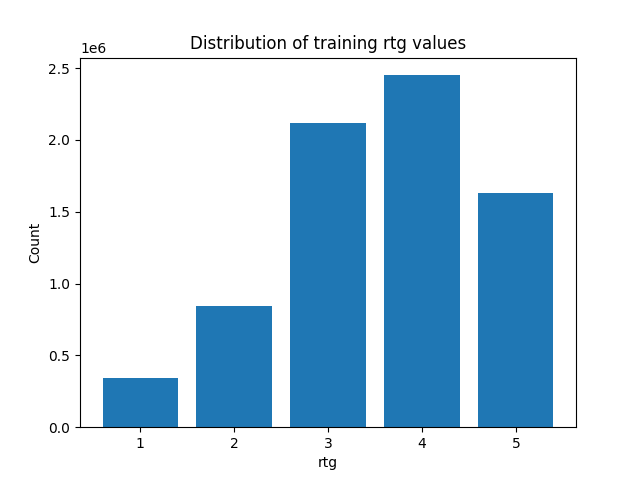

In [ ]:
# # see how many ratings each user has given
# # potentialy helpful for dimensionality reduction (one of the starter ideas)
# user_counts = df.groupby('uid')['rtg'].count()

# plt.figure(figsize=(10,5))
# sns.kdeplot(user_counts, color='darkblue')
# plt.title('Number of ratings per user')
# plt.xlabel('Number of ratings')
# plt.ylabel('Density')
# plt.show()

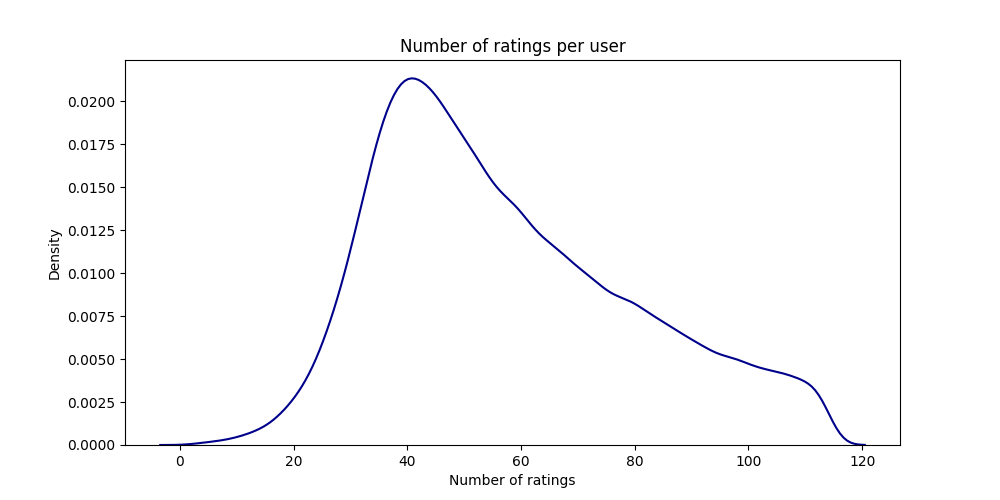

In [ ]:
# # # movies with the highest average ratings (suggesting they are universally liked/disliked)
# # # ultimately used to help with PCA in our model
# mean_ratings = df.groupby('mid')['rtg'].mean()
# top_movies = mean_ratings.sort_values(ascending=False).head(10)
# bottom_movies = mean_ratings.sort_values(ascending=True).head(10)

# print(f'Movies with highest average ratings: {top_movies}')
# print(f'Movies with lowest average ratings: {bottom_movies}')

# # output:
# # Movies with highest average ratings: mid
# # 14     4.26
# # 7      4.25
# #        ...
# # 59     4.08
# # 275    4.03
# # Name: rtg, Length: 10, dtype: float64
# # Movies with lowest average ratings: mid
# # 375    2.25
# # 252    2.36
# #        ...
# # 298    2.62
# # 264    2.62
# # Name: rtg, Length: 10, dtype: float64

Movies with highest average ratings: mid
14     4.26
7      4.25
       ... 
59     4.08
275    4.03
Name: rtg, Length: 10, dtype: float64
Movies with lowest average ratings: mid
375    2.25
252    2.36
       ... 
298    2.62
264    2.62
Name: rtg, Length: 10, dtype: float64


## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

**Student's answer:**

Our team's model implementation involved several strategies to handle and analyze the data effectively. Here's an explanation of each method:

1. **Imputing by Mean:** We tried a mean imputation method to replace missing values in the dataset with the mean value of the respective column or row. We used this as a baseline approach to handle missing values. We tried different variations of the mean imputation:

   - Using the same mean for all users based on a larger user-item (uid-mid) matrix.
   - Using the average of dfX (which contains the user-item interactions), similar to our baseline model.
   - Using the median (the middle value) of dfX instead of the mean.
   
   Despite these variations, none of the models showed improvement over the baseline on the Kaggle test set.

2. **Imputing by Adding Bias Terms:** The idea here was to account for the personal biases of the users and the inherent characteristics of the movies. For instance, some users might be harsher or more lenient in their ratings (user bias), and some movies might generally be rated higher or lower regardless of the audience (item bias). We introduced bias terms to capture these effects by:

   - Computing a user bias term as the difference between the overall mean movie rating and the mean rating of each user. This approach aimed to identify users who tend to rate higher or lower than average, but this addition didn't significantly improve our model.
   
3. **Imputing via LDA after PCA Transform:** Another approach was to apply Linear Discriminant Analysis (LDA) on the Principal Component Analysis (PCA) transformed data. This was particularly applied to the most difficult-to-discern ratings (1's and 5's) because our mean imputation method was overestimating ratings around the median (3's and 4's). We applied this method to the most rated movies (the 'data-rich' ones). Although the accuracy on cross-validation wasn't very high (around 0.5), given the skewed distribution of the data, we felt this would be an improvement from mean imputation.

4. **Robust PCA:** Finally, we tried robust PCA to decompose the matrix into a low-rank and a sparse matrix. The low-rank matrix would capture the gross structure while the sparse matrix captures the outliers. Unfortunately, this method didn't prove helpful in improving the imputation.

Despite the variety of methods we tried, our team's improvements over the baseline model stayed somewhat limited.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
if 'dfMtx' in vars(): del dfMtx   # release ~400MB RAM
dfK = df[df.rtg!=df.rtg]          # uid-mid-rtg for Kaggle submission (contains NaN ratings)
dfX = df[df.uid.isin(dfK.uid.unique())]  # all ratings on users requiring predictions (as adjacency list)
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')  # convert to (adjacency) matrix format
dfX_est = dfX.fillna(dfX.mean())  # fill NaN with movies' average ratings, save as
n, p = dfX.shape                  # number of users and movies

In [ ]:
# create lists of the movie IDs with the highest and lowest ratings (determined in EDA)
high_ratings = [14, 7, 122, 126, 183, 67, 16, 155, 59, 275]
low_ratings = [375, 252, 202, 37, 287, 377, 308, 369, 298, 264]
m_list = high_ratings + low_ratings

In [ ]:
# create a copy of the original dataset.
d = dfX.copy()

# create a mask indicating where the data is not missing.
mask = ~np.isnan(dfX)

In [ ]:
# iterate through the movie IDs and use PCA and LDA to estimate missing ratings.
for i in m_list:
  # drop the current movie column and fill missing values with zeros.
  d = d.drop(i, axis = 1).fillna(0)

  # apply PCA and reduce the data to 10 components.
  pca = PCA(n_components = 10)
  dp = pd.DataFrame(pca.fit_transform(d), index = d.index)

  # apply LDA to predict the missing ratings.
  lda = LinearDiscriminantAnalysis()
  ty = dfX[dfX[i].notna()]  # only select rows where the current movie rating is not missing.
  lda.fit(dp.loc[ty.index.tolist()], ty[i])  # fit the LDA model.
  yi = lda.predict(dp)  # Predict the missing ratings.

  # add the predicted ratings to the dataframe.
  d[i] = yi

  # replace the predicted values with the original ones that were known/not missing.
  d[mask] = dfX[mask]

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

In [ ]:
# reorder the columns in ascending order.
sorted_columns = sorted(d.columns, key=lambda x: int(x))
dnew = d[sorted_columns]

# replace the zero values with the average rating of each movie.
dfX_est = dnew.replace(0, dfX.mean())
n, p = dfX.shape

In [ ]:
'''
#%%#adding movie combination
mu = df['rtg'].mean()
movie_avgs = (dfX.fillna(mu) - mu).mean().tolist()
for i, col in enumerate(dfX.columns):
    dfX_est.loc[:,col] = dfX_est.loc[:,col].values + (movie_avgs[i])
#%%
user_ratings = (dfX.mean(axis=1) - df['rtg'].mean()).tolist()
for i, row in enumerate(dfX_est.columns):
    dfX_est.iloc[row,:] = dfX_est.iloc[row, :].values + user_ratings[i]
#%%              # number of users and movies
'''

"\n#%%#adding movie combination\nmu = df['rtg'].mean()\nmovie_avgs = (dfX.fillna(mu) - mu).mean().tolist()\nfor i, col in enumerate(dfX.columns):\n    dfX_est.loc[:,col] = dfX_est.loc[:,col].values + (movie_avgs[i])\n#%%\nuser_ratings = (dfX.mean(axis=1) - df['rtg'].mean()).tolist()\nfor i, row in enumerate(dfX_est.columns):\n    dfX_est.iloc[row,:] = dfX_est.iloc[row, :].values + user_ratings[i]\n#%%              # number of users and movies\n"

In [ ]:
# apply SVD to further reduce the noise in the ratings.
np.random.seed(0)
for _ in range(15):
  U, D, Vt = svds(dfX_est.to_numpy(), k=10) # find k eigenvectors (U,V) and eigenvalues (D)
  dfX_est.iloc[0:n, 0:p] = U @ np.diag(D) @ Vt # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)
  mask = ~np.isnan(dfX) # mask locations of NaNs
  dfX_est[mask] = dfX[mask] # place original/known ratings back into estimated uid×mid matrix

# Submissions are scored on accuracy, not on continuous/regression error
# round the estimated ratings to integers and restrict the range to 1-5.
dfX_est_L = dfX_est.unstack().reset_index().round(0).astype(int).rename(columns={0:'rtg'})
dfK = dfX_est_L.merge(dfK, on=['mid','uid'], suffixes=['','_']).drop('rtg_', axis=1)
dfK.index = (dfK.uid-1)*dfK.mid.max()+dfK.mid
dfK['rtg'] = dfK['rtg'].clip(1, 5) # restrict the range to 1,2,3,4,5 . Thanks to Yannis & Liz, See Piazza @67_f1

In [ ]:
# # evaluate unconditional distributions of observed and predicted ratings. Learn from the differences to focus on wrong predictions
# plt.subplot(1, 1, 1)
# _ = df.rtg.dropna(axis=0).astype(int).hist(density=True, alpha=0.3)
# _ = dfK.rtg.astype(int).hist(density=True, alpha=0.3)
# _ = plt.legend(['actual','predicted'])

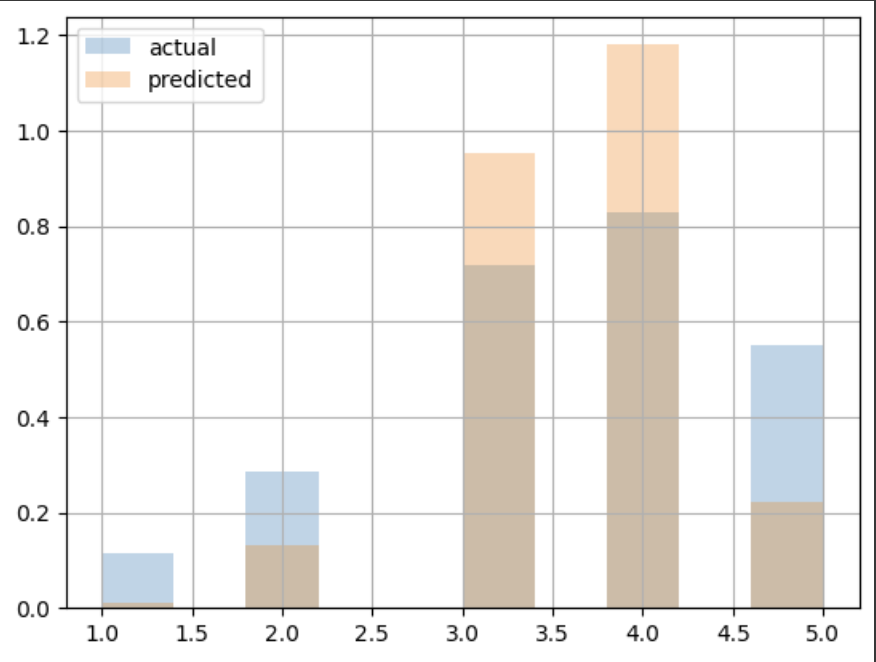


In [ ]:
ToCSV(dfK[['rtg']].sort_index(), 'group12_submission')
# gives public leaderboard score of #0.418

# **References:**

1. Géron, A. (2017). Hands-On Machine Learning with Scikit-Learn and TensorFlow.

1. AT&T Tech Channel (Jan 28, 2010). "From the Labs: winning the Netflix Prize." Retrieved from https://www.youtube.com/watch?v=ImpV70uLxyw

1. Sundog Education with Frank Kane (Jan 28, 2010). "Using Singular Value Decomposition (SVD) for Movie Recommendations." Retrieved from https://www.youtube.com/watch?v=8wLKuscyO9I

1. Scikit-learn. sklearn.decomposition.PCA — scikit-learn 1.0.1 documentation. Scikit-learn. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

1. Scikit-learn. sklearn.discriminant_analysis.LinearDiscriminantAnalysis — scikit-learn 1.0.1 documentation. Scikit-learn. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 48 sec


## 💡**Starter Ideas**

1. Tune model **hyperparameters**.
  1. SVD's $k$ might be user-perceived movie genres (perhaps, an average user categorizes movies into just 5 or 50 genres) [🎦](https://youtu.be/sooj-_bXWgk)
1. Try smarter **sampling** from the training set to avoid using all observations (due to time constraint)
  1. Some movies may have consistent high/low ratings and do not distinguish user preferences (just add to runtime)
1. Try SVD on groups (say movie genres) with the largest impact on overall accuracy
1. Try smarter initial imputation, perhaps, conditioned on movie genres or other observed features
1. Try clustering techniques from [SKL](https://scikit-learn.org/stable/modules/clustering.html)
1. Try engineering new features using Movies' data (`movies.csv`)
1. Try supervised approach on clusters or engineered features
1. Try shift/scale ratings. Recall: SVD seeks largest quadratic error from mean without shifting first, like variance does. Since $1^2\ll5^2$, SVD might work better for higher ratings.
  1. Note: the baseline model squeezes predictions towards ratings 3 and 4, which is not the original distribution.
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA. Are there movies that are liked by most viewers?
1. Try Robust PCA (RPC) [🎦](https://www.youtube.com/watch?v=yDpz0PqULXQ), [RPCA Github](https://github.com/dganguli/robust-pca)
1. Find polarized movies and tune for them (like "*Napoleon Dynamite*"). See [&#127910;](https://youtu.be/ImpV70uLxyw)
1. Try KNN [📄](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.143.596&rep=rep1&type=pdf), [📄](https://scholar.google.com/scholar?q=knn+netflix+prize)
1. Learn more methods to build/use latent representations [🎦](https://youtu.be/n3RKsY2H-NE),  [📄](https://ieeexplore.ieee.org/abstract/document/5197422), [📄](https://scholar.google.com/scholar?q=netflix+prize+challenge), [&#127910;](https://www.youtube.com/results?search_query=netflix+prize+svd), [📄](https://www.aaai.org/Papers/AAAI/2002/AAAI02-029.pdf),